# Airfield Noise Monitoring with Deep Acoustic Clustering

Continued exposure to aircraft noise is a persistent environmental issue with serious health concerns, including increased reliance on sleep aids and increased risk of heart disease, especially for communities living in close proximity to airfields ([Franssen 2004](https://oem.bmj.com/content/61/5/405); [Torija 2018](https://www.researchgate.net/profile/Antonio-Torija/publication/322328656_Aircraft_classification_for_efficient_modelling_of_environmental_noise_impact_of_aviation/links/5aaabc2845851517881b4434/Aircraft-classification-for-efficient-modelling-of-environmental-noise-impact-of-aviation.pdf)). To protect these communities, noise monitoring around airports remains a cruicial tool ([Asensio 2012](https://www.sciencedirect.com/science/article/abs/pii/S0003682X11002477)). 

Unfortunately, the automated identification of aircraft noise in residential environments can be challenging, due to the confounding presence of additional anthropogenic noise sources ([Tarabini 2014](https://www.sciencedirect.com/science/article/abs/pii/S0003682X1400070X)). To discriminate between these confounding sources, several techniques have been employed including acoustic classification ([Asensio 2010](https://oa.upm.es/7652/2/INVE_MEM_2010_80172.pdf)), noise coincidence with airfield radar tracks ([Timmerman 1991](https://asa.scitation.org/doi/10.1121/1.2029280)), and coincidence with ADS-B tracks ([Giladi 2020](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7481859/pdf/main.pdf)).

In this work, we apply a deep neural network to perform feature extraction and unsupervised clustering on acoustic recordings at an airfield. We then provide a framework for rapidly classifying the clusters via human-machine teaming. Finally, we demonstrate a k-nearest-neighbors algorithm for the automated identification of aircraft noise vs other urban noise sources.

This work represents the first end-to-end discriminative airfield noise monitoring solution that requires only a single microphone with no external knowledge of airfield activities, significantly reducing the barrier to entry for accurate airfield noise monitoring. 

-Dr. Josh Dickey

We have clustered spectrograms and 

In [1]:
# Import Basic Python Functionality
import numpy as np
import pandas as pd
import subprocess
from pytube import YouTube
from pydub import AudioSegment
import copy
import random
import datetime
import time
import sys
import re
import os
import io
from os import walk
import scipy.io.wavfile
from scipy import signal
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cm as cm
import seaborn as sns
import matplotlib.dates as mdates
import string
from pathlib import Path


#Import Python Libraries for Machine Learning
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, v_measure_score
from sklearn.preprocessing import MinMaxScaler, normalize, LabelBinarizer, minmax_scale
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import pairwise_distances, pairwise_distances_argmin_min
from sklearn.neighbors import KNeighborsClassifier


# Import Keras/Tensorflow Libraries for Deep Learning
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, Callback
from tensorflow.keras import Input
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, Flatten, Activation, Lambda, Convolution1D, Dense, add, Lambda
from tensorflow.keras.applications import xception
import tensorflow_addons as tfa
#import tensorflow_datasets as tfds
import leaf_audio.frontend as frontend
from leaf_audio import frontend, initializers
import functools

#GUI Components
from pydub.playback import play
import ipywidgets as widgets
from ipywidgets import interact
from tkinter import * 
from tkinter import ttk
from tkinter.ttk import *
from IPython.display import display
from IPython.display import Image


%matplotlib inline


def vdir(directory): #verify a directory exists, if not make it
    if not os.path.exists(directory): os.mkdir(directory)
    return directory

data_folder=vdir('data')
more_folder=vdir('more')
downloads_folder=vdir(data_folder+'/downloads')
npys_folder=vdir(data_folder+'/npys')
time_series_npys_folder=vdir(npys_folder+'/time_series_audio_npys')
audio_set_npys_folder=vdir(npys_folder+'/audio_set_npys')
drone_npys_folder=vdir(npys_folder+'/drone_audio_npys')

time_series_downloads_folder=vdir(downloads_folder+'/time_series_audio_mp4s') #long time-series mp4 files go in here
audio_set_downloads_folder=vdir(downloads_folder+'/audio_set_mp4s') #short mp4 files from google's AudioSet data go here
drone_downloads_folder=vdir(downloads_folder+'/drone_audio_wavs')
data_collector_folder=vdir(more_folder+'/data_collector')

model_folder = vdir('models')
log_folder = vdir('logs')

Train_from_scratch = True

physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#TF_GPU_ALLOCATOR=cuda_malloc_async
print("tf version:",tf.__version__)
print(physical_devices)


tf version: 2.7.3
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-06-22 07:27:21.402167: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 07:27:21.449053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 07:27:21.449573: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
pdict = {}
pdict['r_smp'] = 44100

#Important Functions for Later:
def pydub_to_np(audio, frame_rate=pdict['r_smp']): #Converts pydub audio segment into np.float32 of shape [duration_in_seconds*sample_rate, channels], where each value is in range [-1.0, 1.0]. Returns audio_np_array
    audio.set_frame_rate(frame_rate)
    return np.array(audio.get_array_of_samples(), dtype=np.float32).reshape((-1, audio.channels)) / (1 << (8 * audio.sample_width - 1))
def xlr(lrb): #used to read the left or right audio parameter quickly
    return 0 if lrb=='L' else 1 if lrb=='R' else np.random.randint(2)
def sequence_to_spectrogram(s,samps_per_second,v_res,f_len,t_len): #takes in a sequence (1 ch) and ouputs it as a log spectrogram in greyscale (1 ch)
    _, _, spectrogramx = signal.spectrogram(s,samps_per_second,nperseg=v_res)
    log_spectrogram=np.log10(spectrogramx[:f_len,:t_len],out=spectrogramx[:f_len,:t_len],where=spectrogramx[:f_len,:t_len] > 0)
    diff=np.max(log_spectrogram)-np.min(log_spectrogram)
    spectrogram=(log_spectrogram-np.min(log_spectrogram))/diff if diff!=0 else log_spectrogram-np.min(log_spectrogram)
    return spectrogram
def norm_seq_to_spg(s,samps_per_second,v_res,f_len,t_len,filt):
    s = s/(np.max(np.abs(s))+1e-8) #first normalize the window
    sp = sequence_to_spectrogram(s,samps_per_second,v_res,f_len,t_len) - filt
    sp = sp - np.min(sp) #now normalize the spectrogram
    sp = sp/(np.max(sp)+1e-8)
    return sp

## Time-Series Data

First we start with several unlabeled airport audio streams

In [3]:
vidLnk = {}
#unlabeled data
#vidLnk['Haneda_Airport'] = "https://www.youtube.com/watch?v=tyD-i1u8f5g"
#vidLnk['Chitose_Airport'] = "https://www.youtube.com/watch?v=PxRwSvBeEvA"
#vidLnk['Narita_Airport'] = "https://www.youtube.com/watch?v=TGhl84_TUnU"
#vidLnk['Funchal_Airport'] = "https://www.youtube.com/watch?v=5RfiTxR9-d8"
#vidLnk['Lisbon_Airport'] = "https://youtu.be/Z7CutgNEMfA"
#vidLnk['Brussels_Airport'] = "https://youtu.be/CaiFfQTdRz0"
#vidLnk['Amsterdam_Airport_2'] = "https://youtu.be/1ll4mumGBxk"
#vidLnk['Zurich_Airport'] = "https://youtu.be/aTyQ4fJtwhc"

#labeled data
vidLnk['Houston_Airport'] = "https://www.youtube.com/watch?v=dNTv7g1f5S0"
vidLnk['Amsterdam_Airport_1'] = "https://www.youtube.com/watch?v=f_74vfnFRzk"
vidLnk['Berlin_Airport'] = "https://youtu.be/fPzpohpnW5Y"
outfiles = []

for video_name in vidLnk:
    video_link = vidLnk[video_name]
    video_file = os.path.join(time_series_downloads_folder, video_name+'.mp4')
    audio_file = os.path.join(time_series_npys_folder, video_name+f'_{pdict["r_smp"]}.npy')
    outfiles.append(audio_file)
    print(f'{video_name}:', end='\t')
    
    if not os.path.exists(video_file):
        try:
            print(f'Downloading...', end=' ')
            video = YouTube(video_link)
            audio = video.streams.filter(only_audio=True, file_extension='mp4').first()
            audio.download(filename=video_file)
            print('Complete!', end='\t')
        except:
            print("Error!")  # to handle exception   
    else:
        print('Already Downloaded!', end='\t')            
            
    if (os.path.exists(video_file)) & (not os.path.exists(audio_file)):
        try:
            print(f'Converting...', end=' ')
            seg = AudioSegment.from_file(video_file, format="mp4")
            samples = pydub_to_np(seg, pdict['r_smp'])
            np.save(audio_file, samples)
            print('Complete!', end='\t')
        except:
            print("Error!")  # to handle exception   
    else:
        print("Already Converted!")  

Houston_Airport:	Already Downloaded!	Already Converted!
Amsterdam_Airport_1:	Already Downloaded!	Already Converted!
Berlin_Airport:	Already Downloaded!	Already Converted!


# Labeled Data

## Generator C

Uses labelled data and grabs nK unique or random windows from nP unique or random labels (depending on how big nP and nK are and how small the data set is)

In [4]:
def generatorC(data_array,pdict,class_groups,return_startpoints=False): 
    
    nP=pdict['numP']
    nK=pdict['numK']
    window_size_secs=pdict['w_sec']
    samps_per_second=pdict['r_smp']
    lrb=pdict['LRB']
    
    window_samps=int(window_size_secs*samps_per_second)
    
    bs=nP*nK #batch size
    
    skip_n=nP-(len(class_groups)-class_groups.count([]))<=0 #if true we skip the independent picks process and just let repeated labels occur because otherwise we'd have a hard limit of nP=18
    
    while 1:
        
        startpoints=[]
        labels_gen=[]
        windows=np.zeros((bs,window_samps))
        
        for p in range(nP):
            sm_i,tmp_cgroup=0,[] 
            while tmp_cgroup==[] or (sm_i in labels_gen if skip_n else None): #skip_n is in there incase nP is greater than the number of examples for that given class
                sm_i=np.random.randint(len(class_groups))
                tmp_cgroup=class_groups[sm_i] #choose a random non-empty non-repeated segment (the larger rng is the less time this takes)
            #i will be our label and tmp_cgroup will be our data_array indices to randomly pick windows from 
            np.random.shuffle(tmp_cgroup)
            
            #now sm_i is our current class and tmp_cgroup is our current classgroup 
            for k in range(nK):
                batch_idx=p*nK+k
                tmp_c=tmp_cgroup[k] if k<len(tmp_cgroup) else tmp_cgroup[np.random.randint(len(tmp_cgroup))] #we want a random choice of the current classgroup (a random file from that class) but we don't want repeated files if we can avoid it so this is an ordered selection of the random shuffled tmp_cgroup until it runs out of options, then its just a random choice
                dind=tmp_c[0]
                carr=data_array[dind]
                
                #Here we choose a window based around our time segment data
                #The way I approached this was to imagine two cases, one where the window is larger than the event time frame and one where the window is shorter than that event time frame
                #t_ind=np.random.choice([i for i,smsmlbs in enumerate(labels[dind]) if smsmlbs==sm_i])#randomly chooses a valid labels index where the current class exists in that file
                [ll,ul]=tmp_c[1] #lower and upper limits of the event time frame
                
                [tl,tu]=np.sort([ll,ul-window_samps])#let's take care of 2 possibilities at once, one the window is smaller than the event time frame (if window_samps<ul-ll then we want samp=np.random.randint(ll,ul-window_samps)), and two the window is larger than the event time frame(if window_samps>ul-ll then we want samp=np.random.randint(ul-window_samps,ll))
                if tl<0: tl=0 #incase ul-window_samps above gives a negative number
                if tu+window_samps>len(carr): tu=len(carr)-window_samps #incase ll above is also close to the end, this moves it back

                samp=np.random.randint(tl,tu) if tl!=tu else tl #if tl==tu then np.random.randint will give an error so we just give it the exception
                
                window = carr[samp:samp+window_samps,xlr(lrb)] #if you are getting an error here check your window size and make sure its within your data's size
                
                labels_gen.append(sm_i)
                startpoints.extend([dind,samp])
                windows[batch_idx]=window
                
        if return_startpoints:
            yield windows, np.array(labels_gen).astype(int), startpoints
        else:
            yield windows, np.array(labels_gen).astype(int)

            
# Additional functions for labeled data:
def class_grouper(labels_c,times,n_classes): #returns a list of file and time references for a given class (index). i.e. class_groups[3] contains all the [file, [time]] references for class 3
    class_groups=[]
    for c in range(n_classes):
        tmp_cgroup=[]
        for i in range(len(labels_c)):
            for j in range(len(labels_c[i])):
                if labels_c[i][j]==c:
                    tmp_cgroup.append([i,times[i][j]])
        class_groups.append(tmp_cgroup)
    return class_groups

def cg_splitter(class_groups,split): #splits class_groups into train, validation, and test sets
    if len(split)>2: split=split[-2:] #incase someone accidentally inputs [0.7,0.15,0.15] instead of [0.15,0.15] for example
    trn,val,tst=[],[],[]
    for i in range(len(class_groups)):
        tvn=[int(np.ceil(len(class_groups[i])*spl)) for spl in split]
        ttvn=[len(class_groups[i])-np.sum(tvn)]+tvn
        [a1,a2,a3]=[np.sum(ttvn[:j+1]) for j in range(len(ttvn))]
        trn.append(class_groups[i][:a1])
        val.append(class_groups[i][a1:a2])
        tst.append(class_groups[i][a2:])
    return trn,val,tst

def dctvt(airports,csv_files,split,pdict): #loads the data and labels, then organizes everything and outputs the data and classes along with the train, val, and test class_groups 
    #load the data
    numpy_files=[os.path.join(time_series_npys_folder, f) for f in os.listdir(time_series_npys_folder) if Path(f).suffix == '.npy']
    data=[np.load(numpy_files[np.where([airport in filename for filename in numpy_files])[0][0]]) for airport in airports]

    #import label data, all preformatted as label, event_start(s), event_stop(s)
    times=[(pd.read_csv(data_collector_folder+'/'+file)[['start','stop']].to_numpy()*pdict['r_smp']).tolist() for file in csv_files]
    labels=[pd.read_csv(data_collector_folder+'/'+file).to_numpy().T[0].tolist() for file in csv_files]

    #generate class indices
    classesp={st:i for i,st in enumerate(np.unique([lbl for arr in labels for lbl in arr]))}
    l_c=lambda labels:[classesp[lbl] for lbl in labels]
    labels_c=[l_c(l) for l in labels]

    #create class_groups, then only keep the ones with 3 or more examples
    cgp=class_grouper(labels_c,times,len(classesp))
    class_groups,classes=[],[]
    for i in range(len(cgp)):
        if len(cgp[i])>2: #here we are removing any classes with only one reference example, we can change this to be 1 if we just want train-test sets
            class_groups.append(cgp[i])
            classes.append(list(classesp)[i])
    #split the class_groups
    cg_trn,cg_val,cg_tst=cg_splitter(class_groups,split)
    
    return data, classes, cg_trn, cg_val, cg_tst

def genC_plot(nP,nK,xy,ls,sps,classes,files_as_labels=False): #plots generatorC
    fig, ax = plt.subplots(nP, nK, figsize=(20,nP*2))
    for p in range(nP):
        for k in range(nK):
            idx = p*nK+k    
            label = ls[idx]
            ax[p,k].plot(xy[idx])
            ax[p,k].set_xticklabels([])
            ax[p,k].set_yticklabels([])
            if files_as_labels:
                ax[p,k].set_xlabel(str(sps[2*idx]))
            else:
                ax[p,k].set_xlabel(""+str(sps[2*idx])+"    "+str(sps[2*idx+1]//(pdict['r_smp']*60)))
        ax[p,0].set_ylabel(classes[label])

### class_groups demo
This is what class_groups is, it contains all the class, file, label, and event time data. Below is a basic example of how it combines everything

In [5]:
classes=['class0','class1','class2'] #these classes are referred to as their index below so for example classes[0] is class0

#files and times are connected by labels to form classgroups. labels contains references to the class each timestamp is in and all the classes each file contains.
files=['a.npy','b.npy','c.npy']
labels_c=[[2,2,0],[1],[1,0]] #labels_c is indexed by file and numbered by class index so labels_c[0][1]=2 is a reference to file 0, and classes[2]
times=[[[0,12],[0,15],[2,4]],[[3,4]],[[0,10],[6,7]]] #times matches the indexing of labels_c to make it so times[i][j] is the supplemental event-time range for labels_c[i][j]

#now pull what you need from files and times
class_groups=[]
for c in range(len(classes)):
    tmp_cgroup=[]
    for i in range(len(labels_c)):
        for j in range(len(labels_c[i])):
            if labels_c[i][j]==c:
                tmp_cgroup.append([i,times[i][j]]) #notice how i is just the reference for our files[i]. This can also be used to reference the actual i'th data array
    class_groups.append(tmp_cgroup)
for i in range(len(classes)):
    print(classes[i],': ',class_groups[i]) 
#this entire process can be done in one line using np.squeeze, but it is much harder to interpret in my opinion:
#[np.squeeze([[[files[i],i,times[i][j]] for j in range(len(labels_c[i])) if labels_c[i][j]==c] for i in range(len(labels_c)) if c in labels_c[i]]).tolist() for c in range(len(classes))]

class0 :  [[0, [2, 4]], [2, [6, 7]]]
class1 :  [[1, [3, 4]], [2, [0, 10]]]
class2 :  [[0, [0, 12]], [0, [0, 15]]]


Above we can see that the indices of class_groups corresponds directly with the indices of our classes, so class_groups[0] contains all the example references for classes[0]

Now the way we would read this is that we can find an example of class 0 in files[0] from time 2 to 4. another example of class 0 occurs in files[2] from time 6 to 7.

## Labeled Time-Series Aircraft Audio
Here we have labeled some long youtube videos with different aircrafts' noises

In [2]:
pdict={}
pdict['r_smp'] = 44100

#Houston, Berlin, and Amsterdam data
airports = ["Amsterdam_Airport_1"] #["Houston","Berlin","Amsterdam_Airport_1"]
csv_files = ['amsterdam.csv'] #['houston.csv','berlin.csv','amsterdam.csv']
split = [0.7,0.15,0.15] #a classic 70 15 15 split would be [0.15,0.15]

ts_data, ts_classes, ts_cg_trn, ts_cg_val, ts_cg_tst = dctvt(airports,csv_files,split,pdict) #did this in a function just incase we want to split up datasets

NameError: name 'dctvt' is not defined

In [1]:
ts_classes

NameError: name 'ts_classes' is not defined

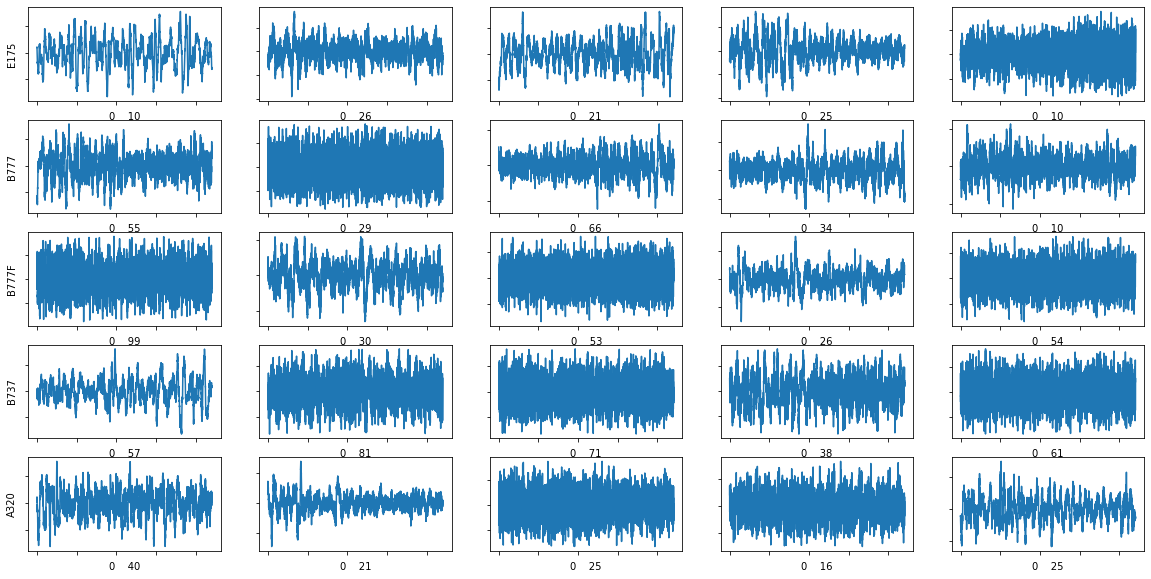

In [7]:
# GeneratorC Parameters
pdict={}
pdict['r_smp'] = 44100
pdict['w_sec'] = 1
pdict['numP'] = 5
pdict['numK'] = 5
pdict['LRB'] = 'B'

# Generator instantiation
test_genC=generatorC(ts_data,pdict,ts_cg_trn,return_startpoints=True)
xy,ls,sps=next(test_genC)

genC_plot(pdict['numP'],pdict['numK'],xy,ls,sps,ts_classes)

## Labeled Drone Audio Data

Here we are just converting the drone audio data from this dataset https://github.com/saraalemadi/DroneAudioDataset

In [ ]:
pdict={}
pdict['r_smp'] = 16000
pdict['w_sec'] = 1
pdict['ch'] = 3
pdict['LRB'] = 'L'
pdict['vres'] = 2**9

bc = 0 #multiclass 0, binary class 1
drone_classes=['not_drone','drone1','drone2'] #['not_drone','drone'] #binary

#make a list of the wav files
drone_wav_files=[[root+'/'+file for file in np.sort(files)] for root,dirs,files in os.walk(drone_downloads_folder) if files!=[]]
drone_wav_files=[drone_wav_files[0:3],drone_wav_files[3:]] #non-general but shorter than the alternative

#create all the new npy directories 
[vdir(folder) for folder in [root.replace(drone_downloads_folder,drone_npys_folder) for root,dirs,files in os.walk(drone_downloads_folder)]]

#make new npy filenames
drone_npy_files=[[[f.replace(drone_downloads_folder,drone_npys_folder).replace('.wav','.npy') for f in sd] for sd in d] for d in drone_wav_files]

#Convert the wavs to npys
for i in range(len(drone_wav_files)):
    for j in range(len(drone_wav_files[i])):
        if not os.path.exists(drone_npy_files[i][j][-1]):
            for k in range(len(drone_wav_files[i][j])):
                seg = AudioSegment.from_file(drone_wav_files[i][j][k], format="wav")
                samples = pydub_to_np(seg, pdict['r_smp'])
                np.save(drone_npy_files[i][j][k], samples)

#load the new npy files all in one list
def fldt(drone_npys,lbl):
    f_=[f for f in drone_npys]
    l_=[[lbl] for f in f_]
    d_=[np.load(f) for f in f_]
    t_=[[[0,len(d)]] for d in d_]
    return f_,l_,d_,t_
f__,l__,d__,t__=[],[],[],[]
for i in range(len(drone_npy_files[bc])):
    f_i_,l_i_,d_i_,t_i_ = fldt(drone_npy_files[bc][i],i)
    f__.extend(f_i_); l__.extend(l_i_); d__.extend(d_i_); t__.extend(t_i_)
shuffled=np.random.permutation(len(f__))
drone_files=np.array(f__)[shuffled].tolist()
drone_labels=np.array(l__)[shuffled].tolist()
drone_data=np.array(d__,dtype='object')[shuffled].tolist()
drone_times=np.array(t__)[shuffled].tolist()
prev_size=len(drone_data)

#pop out all the lengths under w_sec
lengths_under_Ws=[i for i,d in enumerate(drone_data) if len(d)<pdict['r_smp']*pdict['w_sec']]
lengths_under_Ws.reverse()
for i in lengths_under_Ws:
    drone_files.pop(i)
    drone_labels.pop(i)
    drone_data.pop(i)
    drone_times.pop(i)


drone_classgroups = class_grouper(drone_labels,drone_times,len(drone_classes))
#drone_classgroups=[[i for i in range(len(drone_labels)) if drone_labels[i][0]==cl] for cl in range(3-bc)] #3-bc is 2 for binary and 3 for multiclass
print("data remaining:",len(drone_data),"/",prev_size) #if this number gets too low try setting w_sec lower

In [ ]:
#dropout some classgroups from the not a drone class to make the classes more evenly distributed (50-50 drone-not a drone)
popn=len(drone_classgroups[0])-(len(drone_classgroups[1])+len(drone_classgroups[2]))
for pop in range(popn):
    drone_classgroups[0].pop(np.random.randint(len(drone_classgroups[0])))
len(drone_classgroups[0])

In [ ]:
def fdltc(lb,ub):
    f_=drone_files[lb:ub]
    #l_=drone_labels[lb:ub]
    #t_=drone_times[lb:ub]
    d_=drone_data[lb:ub]
    c_=[[[i-lb,time] for [i,time] in drone_classgroups[j] if i<ub and i>=lb] for j in range(len(drone_classgroups))]
    return f_,d_,c_
def splitter(splits):
    inds,prev=[0],0
    for split in splits:
        inds.append(prev+int(split*len(drone_files)))
        prev=inds[-1]
    inds.append(len(drone_files))
    return inds
bounds=splitter([0.7,0.15]) #70,15,15

drone_f_trn, drone_d_trn, drone_c_trn = fdltc(bounds[0],bounds[1])
drone_f_val, drone_d_val, drone_c_val = fdltc(bounds[1],bounds[2])
drone_f_tst, drone_d_tst, drone_c_tst = fdltc(bounds[2],bounds[3])

In [ ]:
# GeneratorC Parameters
pdict['numP'] = 5
pdict['numK'] = 5

# Generator instantiation
test_genC=generatorC(drone_d_trn,pdict,drone_c_trn,return_startpoints=True)
xy,ls,sps=next(test_genC)

genC_plot(pdict['numP'],pdict['numK'],xy,ls,sps,drone_classes,files_as_labels=True)


# Leaf Demo

In [ ]:
pdict={}
pdict['f_range'] = [60,16000] #60 7800
pdict['f_res'] = 40 #40
pdict['t_res'] = 25 #25 #not an actual resolution, this is like the time 'bin size' parameter of spectrograms
pdict['r_smp'] = 44100

custom_leaf = frontend.Leaf(learn_pooling=False,
                            n_filters=pdict['f_res'],
                            window_len=pdict['t_res'],
                            sample_rate=pdict['r_smp'],
                            preemp=True,
                            compression_fn=functools.partial(frontend.log_compression, log_offset=1e-5),
                            complex_conv_init=initializers.GaborInit(sample_rate=pdict['r_smp'], min_freq=float(pdict['f_range'][0]), max_freq=float(pdict['f_range'][1])))


In [ ]:
i,j,l=20,50,3
t1,t2,s1,s2=i,i+l,j,j+l
my_sample12=[ts_data[0][t1*44100:t2*44100,0],ts_data[0][s1*44100:s2*44100,0]]
np.array(my_sample12).shape

In [ ]:
tf_data12=tf.constant(np.array(my_sample12))
tf_data12.shape

In [ ]:
my_leaf=custom_leaf(tf_data12)
print(my_leaf.shape)
plt.imshow(tf.transpose(my_leaf[1]),interpolation='nearest',aspect='auto')

In [ ]:
i,l=16,1
my_sample=np.array([[ar[0] for ar in drone_d_trn[i]]])
my_sample.shape

In [ ]:
tf_data=tf.constant(np.array(my_sample))
tf_data.shape

In [ ]:
my_leaf=custom_leaf(tf_data)
print(my_leaf.shape)
plt.imshow(tf.transpose(my_leaf[0]),interpolation='nearest',aspect='auto')

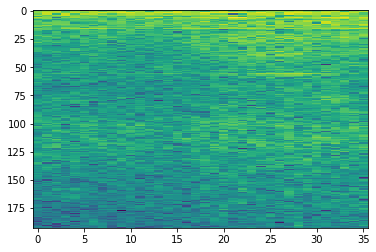

In [19]:
window_size_secs=l
v_res=2**9
window_samps=int(window_size_secs*44100)
t_len=int((window_samps-(v_res/8))/(v_res*7/8))   #These are the time and frequency dimensions of my plot. They come from the scipy spectrogram generation formulas.
f_len=int(.75 * v_res/2)+1
spectrogram = sequence_to_spectrogram(my_sample[0],44100,v_res,f_len,t_len)
plt.imshow(spectrogram,interpolation='nearest',aspect='auto')

# NN Architecture

We use a CNN that implements Triplet Semi-Hard Loss

To understand the Triplet Loss and what it is doing we need to explain the Generator just a bit so the Loss Function makes sense in our context. First we start with the long time-series data stream in raw data form. The job of the generator is to take one random "region" and take nK random spectrogram windows out of that region. We then take a total of nP regions and get out a matrix of spectrograms that is nP x nK = batch size. The actual data fed into the nn is a flattened list of these spectrograms with a labels list that label each spectrogram as the p row (region) it belongs to to give a total of nP labels. (the data shape is batch size x spectrogram height x spectrogram width, and the labels shape is just batch size)

The embeded vectors for all the spectrograms are then created by the neural network and output in the same order so we have an embedding vector list of batch size x output dimensions (which we set to 128). We then generate a distance matrix from all of these vectors and are left with a distance matrix of size batch size x batch size.

The distance matrix is obtained using the euclidian distance which for our case is really just the pythagorean theorem on the difference of vectors in multi dimensions so we treat the vectors as like 128 dimensional cartesian vectors and say **x** = **a** - **b** where **a** and **b** are 128 dimensional vectors and the resultant difference vector is just an element-wise subtraction in cartesian coordinates (x1=a1-b1, x2=a2-b2, etc). We then find the length of **x** by doing x1^2 + x2^2 + x3^2 + ... + x128^2 = dist^2 and we solve for dist^2 (for our purposes we don't really need to take the square root). 

The vectors **a** and **b** are chosen sequentially from our input list of vectors and done in order, we will define the function D(**a,b**) that does just this distance calculation between vector **a** and vector **b**. Let's do an example where we have a case that nP=2 and nK=2, then we will have a batch size of nP x nK = 4 and our y_pred (embeded vector list) will be of shape 4 x 128.

[**v1, v2, v3, v4**]

Given our input shape and the fact that nP=2 and nK=2 we know that we have 2 different classes, we will call them 0 and 1. Here are the labels (y_true)

y_true = [0, 0, 1, 1]

Now the distance matrix will be a 4 x 4 matrix and will look like this:

[D(**v1,v1**), D(**v1,v2**), D(**v1,v3**), D(**v1,v4**),<br>
 D(**v2,v1**), D(**v2,v2**), D(**v2,v3**), D(**v2,v4**),<br>
 D(**v3,v1**), D(**v3,v2**), D(**v3,v3**), D(**v3,v4**),<br>
 D(**v4,v1**), D(**v4,v2**), D(**v4,v3**), D(**v4,v4**)]

Before we continue it should be noted now that all the anchors are now defined. D(a,b) is the anchor-(pos/neg) pair where a is the anchor and b is either a positive or negative match for that anchor.

Based on our y_true labels that come from the generator, we can say that v1 and v2 should be positive to one another, and negative to v3 and v4. Below is the same distance matrix but this time we have highlighted every anchor-positive distance in green and every anchor-negative distance in red.

<span style="color:green">[D(**v1,v1**), D(**v1,v2**),</span> <span style="color:red">D(**v1,v3**), D(**v1,v4**),<span> <br>
 <span style="color:green">D(**v2,v1**), D(**v2,v2**),<span> <span style="color:red">D(**v2,v3**), D(**v2,v4**),<span> <br>
 <span style="color:red">D(**v3,v1**), D(**v3,v2**),<span> <span style="color:green">D(**v3,v3**), D(**v3,v4**),<span> <br>
 <span style="color:red">D(**v4,v1**), D(**v4,v2**),<span> <span style="color:green">D(**v4,v3**), D(**v4,v4**)]<span>
 

$ loss=max(||f(A)-f(P)||^2 - ||f(A)-f(N)||^2+a, 0) $

We have two different types of distances now A-P ($||f(A)-f(P)||^2$) and A-N ($||f(A)-f(N)||^2$), What we want is to increase the distance from the anchor to the negatives while simultaneously decreasing the distance between the anchor and positives. To do this we want to make our loss very high if the A-P distance is large (anchor is far from positive matches) or if the A-N distance is very small (anchor is close to negatives), or conversely to make loss low when A-P distance is small or the A-N distance is large. That is all the base function $||f(A)-f(P)||^2 - ||f(A)-f(N)||^2$ is doing.

Now we also have an added a margin that defines a 'hard' zone where we may have $||f(A)-f(P)||^2 < ||f(A)-f(N)||^2$ (the anchor is slightly closer to a negative than a positive). In Triplet semi-hard loss we take all these "close calls" within the margin a and we train based on those.

This means that we are taking all the possible differences from our distance matrix that are smaller than that value for a and we are using only those to compute loss for a given row. In Josh's custom loss he used the min positive and max negatives for each row to do this calculation but in reality you can take any number of them as long as theyre within the margin.

It is really a general method of determining loss for embeddings and will work just as well on labeled data too (that's actually what it's designed for). The whole thing with siamese shift encoding only really affects the generator to be honest, It is just a data fabrication method when you have unlabeled time series data so you can give it some labels.

It should also be worth mentioning that the Tensorflow Triplet Semi-hard loss function does not require all the classes to be in order like we have set them up. we can input any list of spectrograms with any class order so like y_true=[1,1,5,0,5,0] would be fine, it would take these into account, but all our custom metrics depend on the placement so for our metrics we keep it so similar classes are together ([1,1,5,5,0,0]). 

In [20]:
def leaf_encoder_network(pdict, leaf_model, padding='same'):
    nb_channels = pdict['ch']
    dense_layers  = pdict['d']
    out_dim = pdict['od']
    norm = pdict['n']
    window_samps = int(pdict['w_sec']*pdict['r_smp'])
    input_layer = tf.keras.Input(shape=(window_samps), name="input_raw")
    x = leaf_model(input_layer)
    x = tf.keras.layers.Reshape((K.int_shape(x)[1], K.int_shape(x)[2], 1))(x)
    #x = tf.expand_dims(x,-1) #since conv2D takes in the form of channels, not in raw greyscale format
    #x = tf.image.grayscale_to_rgb(x)
    x = tf.keras.layers.Conv2D(64, 3, data_format='channels_last', padding=padding, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)
    x = tf.keras.layers.Conv2D(128, 3, data_format='channels_last', padding=padding, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)
    x = tf.keras.layers.Conv2D(256, 3, data_format='channels_last', padding=padding, activation="relu")(x)
    x = tf.keras.layers.Conv2D(256, 3, data_format='channels_last', padding=padding, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)
    x = tf.keras.layers.Conv2D(512, 3, data_format='channels_last', padding=padding, activation="relu")(x)
    x = tf.keras.layers.Conv2D(512, 3, data_format='channels_last', padding=padding, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)
    x = tf.keras.layers.Flatten()(x)
    for d in dense_layers:
        x = Dense(d, activation='relu')(x)
        
    # normalize output for cosine similarity
    if norm:
        x = Lambda(lambda xx: K.l2_normalize(xx, axis=1))(x)
    
    output_layer = tf.keras.layers.Dense(out_dim, activation='linear', name='output_dense')(x)
    model = Model(input_layer, output_layer, name="leaf_model")
    
    return model

def load_custom_model(pdict, my_leaf, model_folder='models/'):

    if 'iniW' in pdict.keys():
        print(f'|time:{pdict["iniW"]}')
        model_name = [n for n in os.listdir(model_folder) if f'|time:{pdict["iniW"]}' in n][0][:-3]
        model_file = os.path.join(model_folder, model_name + '.h5')

        print('loading previous model:\n', model_file)
        pdict = name2param(os.path.basename(model_file))
        my_acc, my_k = get_acc(pdict)
        my_loss = tfa.losses.TripletSemiHardLoss()
        model = load_model(model_file, custom_objects={'triplet_loss': my_loss, 'tr_acc': my_acc, 's_knn':my_k, 'my_leaf':my_leaf})
    else:
        model_name = param2name(pdict)
        model_file = os.path.join(model_folder, model_name)

        print('building new model:\n', model_file)
        my_acc, my_k = get_acc(pdict)
        my_loss = tfa.losses.TripletSemiHardLoss()
        model = leaf_encoder_network(pdict, my_leaf)

    o = Adam(learning_rate=pdict['lr'], clipnorm=1.)
                      
    model.compile(loss=my_loss, optimizer=o, metrics=[my_acc,my_k])

    return model, model_name


def get_callbacks(model_name, model_folder, log_folder):
    pdict = name2param(os.path.basename(model_name))
    tensor_foldername = os.path.join(log_folder, model_name)
    #model_filename = os.path.join(model_folder, model_name + '.h5')

    #sv = ModelCheckpoint(filepath=model_filename, monitor='val_loss', save_best_only=True, save_weights_only=False, mode='min')
    #print(os.listdir(model_folder)) ####
    stp = EarlyStopping(monitor='val_loss', min_delta=0, patience=pdict['pat'],
                        verbose=0, mode='min', baseline=None)
    tbd = TensorBoard(log_dir=tensor_foldername)
    file_writer = tf.summary.create_file_writer(tensor_foldername + "/metrics")
    file_writer.set_as_default()

    return [stp, tbd] #[sv, stp, tbd]

def param2name(pdict):
    name = []
    for key in pdict.keys():
        if type(pdict[key]) is list:
            name.append(f'{key}:{"x".join(map(str, pdict[key]))}')
        else:
            name.append(f'{key}:{pdict[key]}')
    return '|'.join(name)


def name2param(name):
    regnumber = re.compile(r'^\d+(\.\d+)?$')
    pdict = dict([p.split(':') for p in name.split('|')])
    for key in pdict.keys():
        if regnumber.match(pdict[key]):
            try:
                pdict[key] = int(pdict[key])
            except:
                pdict[key] = float(pdict[key])
        else:
            if 'x' in pdict[key][:-1]:
                pdict[key] = list(map(int, pdict[key].split('x')))
            try:
                pdict[key] = float(pdict[key])
            except:
                pass
    return pdict

#Custom Metrics

def get_pairwise_dists(x, num_p, num_k):
    # pairwise distances for whole batch
    # (redundant computation but probably still faster than alternative)
    norms = tf.reduce_sum(x * x, 1)
    norms = tf.reshape(norms, [-1, 1])
    dists = norms - 2 * tf.matmul(x, x, transpose_b=True) + tf.transpose(norms)
    dists = K.sqrt(K.relu(dists))

    # get the max intra-class distance for each sample
    max_pos = [tf.reduce_max(tf.slice(dists, [i * num_k, i * num_k], [num_k, num_k]), axis=1) for i in range(0, num_p)]
    max_pos = K.concatenate(max_pos, axis=0)

    # get the min inter-class distance for each sample
    min_neg = []
    for i in range(0, num_p):
        left = tf.slice(dists, [i * num_k, 0], [num_k, i * num_k])
        right = tf.slice(dists, [i * num_k, (i + 1) * num_k], [num_k, (num_p - i - 1) * num_k])
        min_neg.append(tf.reduce_min(K.concatenate([left, right], axis=1), axis=1))
    min_neg = K.concatenate(min_neg, axis=0)

    min_max = K.concatenate([K.expand_dims(max_pos, axis=-1), K.expand_dims(min_neg, axis=-1)], axis=1)
    return min_max, dists

def get_triplet_dists(x, margin=0.5):
    x = K.transpose(x)
    max_pos = tf.gather(x, 0)
    min_neg = tf.gather(x, 1)
    # Use relu or softplus
    L_triplet = K.expand_dims(K.softplus(margin + max_pos - min_neg), 1)
    return L_triplet

#slower speed first iteration, all following are the same speed as get_pairwise_dists
def get_pythagorean_pairwise_dists(x,bs): #same operation as pairwise, I was just seeimg some strange results from get_pairwise_dists so I wrote this instead
    diffs=tf.stack([tf.stack([x[j]-x[i] for i in range(bs)]) for j in range(bs)]) #just the geometric differences between vectors i.e. [x1-x2, y1-y2, z1-z2, etc.]
    return tf.sqrt(tf.reduce_sum(diffs**2,axis=2))#differences squared (x1-x2)^2 then summed then the total square rooted by the pythagorean theorem in multiple dimensions

def get_knn_sum(dists, k, bs):
    #Now we want the lowest k distances in a given row not including the identity position
    #I couldnt find a function for the lowest k numbers so I took the top_k of the negative distances which are also the ones closest to 0 then just negate them at the end
    values,indices=tf.math.top_k(-dists,k=k+1) #we take k+1 because the identity (a vector minus itself is 0 and we don't want those so we grab an extra)
    k1_dists=-values
    #Remember to throw out the identity (do k1_dists[:,1:] to get the non-zero entries)
    fa=tf.reduce_sum(k1_dists[:,1:],axis=1) #function a, take the sum or mean of the dists for a row
    fb=tf.reduce_sum(fa) #function b, take the sum or mean of all the distances 
    return fb #, knn_inacc

def get_acc(pdict):
    nP = pdict['numP']
    nK = pdict['numK']
    margin = pdict['m']
    k = nK-1 #I would recommend nK-1 or less unless maybe you want an idea of how close the clustering groups themselves are to one another
    bs=nP*nK
    
    def s_knn(y_true, y_pred): #on bigData this metric holds no meaning
        dists = get_pythagorean_pairwise_dists(y_pred,bs) #designed for get_pythagorean_pairwise_dists but works with no noticeable difference on get_pairwise_dists, just watch out for those non-zero diagonals
        if tf.shape(dists)!=[]: #workaround for errors on initial empty arrays
            knn_sum = get_knn_sum(dists,k,bs)
            return knn_sum #*tf.cast(inacc+1,tf.float32)
        else:
            return tf.constant([0.0])
    
    def tr_acc(y_true, y_pred):
        min_max, _ = get_pairwise_dists(y_pred, nP, nK)
        loss = get_triplet_dists(min_max, margin)
        pos = K.less(loss, .5)
        return K.mean(pos)

    return tr_acc,s_knn

def get_latest_model():
    model_list = [n for n in os.listdir(model_folder)]; model_list.pop(0) if model_list[0] == '.ipynb_checkpoints' else None
    time_list = np.sort([model_list[i].split(":")[-1].split(".")[0] for i in range(len(model_list))])
    return time_list[-1]

gen_selector = {'ts':['generatorC(ts_data,pdict,ts_cg_trn)','generatorC(ts_data,pdict,ts_cg_val)','generatorC(ts_data,pdict,ts_cg_tst)',len(ts_classes)],
                'drone':['generatorC(drone_d_trn,pdict,drone_i_trn)','generatorC(drone_d_val,pdict,drone_i_val)','generatorC(drone_d_tst,pdict,drone_i_tst)',3],
                'audioset':['generatorC(smallData,pdict,smallInfo)','generatorC(smallData2,pdict,smallInfo2)','generatorC(smallData3,pdict,smallInfo3)',18],
                'gen1':['generator(bigData[:2],pdict,gen1s)','generator([bigData[2]],pdict,gen1s)','generator([bigData[3]],pdict,gen1s)',10],
                'gen2':['generator(bigData[:2],pdict,gen2s)','generator([bigData[2]],pdict,gen2s)','generator([bigData[3]],pdict,gen2s)',10],
                'gen3':['generator3(bigData[:2],pdict)','generator3([bigData[2]],pdict)','generator3([bigData[3]],pdict)',10],
                'gen4':['generator4(bigData[:2],pdict)','generator4([bigData[2]],pdict)','generator4([bigData[3]],pdict)',10],
                } #each gen_selector['...'] is a list: [train gen, val gen, test gen, eval nP]

# Train the Siamese Shift encoder

In [14]:
## Build the model
generator_type='ts'

# Model Parameters
pdict = {}
pdict['pat'] = 10
pdict['d'] = [256,128] #[256, 128] #
pdict['od'] = 128 #128
pdict['n'] = 1
pdict['ch'] = 1

pdict['lr'] = 0.0001 #default to 0.0001
pdict['m'] = 0.2

# Generator Parameters
pdict['r_smp'] = 44100 #16000 #
pdict['w_sec'] = 2
#pdict['s_sec'] = .6
pdict['vres'] = 2**9
#pdict['wres'] = 100
pdict['LRB'] = 'L'
pdict['numP'] = 5

# Generator 4 specific parameters
if generator_type=='gen4':
    pdict['numK1'] = 3
    pdict['numK2'] = 4
    pdict['numK'] = pdict['numK1']+pdict['numK2']
    pdict['numC'] = 10
    pdict['CC'] = 1/200
# Generator 3 specific parameters
elif generator_type=='gen3':
    pdict['numK1'] = 3
    pdict['numK2'] = 2
    pdict['numQ'] = 4
    pdict['numK'] = pdict['numK1']+(pdict['numK2']*(pdict['numQ']-1))
    pdict['CC'] = 1/5
# Generators C,1&2 specific parameter
else:
    pdict['numK'] = 5
    
# Leaf Parameters
pdict['f_range'] = [60,16000] #60 7800
pdict['f_res'] = 40 #40
pdict['t_res'] = 25 #25 #not an actual resolution, this is like the time 'bin size' parameter of spectrograms



# build the generators
gen_trn = eval(gen_selector[generator_type][0])
gen_val = eval(gen_selector[generator_type][1])

my_leaf = frontend.Leaf(learn_pooling=False,
                            n_filters=pdict['f_res'],
                            window_len=pdict['t_res'],
                            sample_rate=pdict['r_smp'],
                            preemp=True,
                            compression_fn=functools.partial(frontend.log_compression, log_offset=1e-5),
                            complex_conv_init=initializers.GaborInit(sample_rate=pdict['r_smp'], min_freq=float(pdict['f_range'][0]), max_freq=float(pdict['f_range'][1])))

# load the model
pdict['time'] = int(time.time())
#pdict['iniW'] = 1654693012
model, model_name = load_custom_model(pdict, my_leaf)
model.summary()

# define the steps per epoch
t_len = 10000 #(len(dataTrain)*3)*dataTrain[0].shape[0]/pdict['r_smp']/pdict['w_sec'] #one file divided by window size  (len(dataTrain)/2)*
v_len = t_len/10 #t_len/10
t_step = 400 #t_len//(pdict['numP']*pdict['numK'])+1  #t_len over batch size plus one so we never have a t_step of 0
v_step = v_len//(pdict['numP']*pdict['numK'])+1

building new model:
 models/pat:10|d:256x128|od:128|n:1|ch:1|lr:0.0001|m:0.2|r_smp:44100|w_sec:2|vres:512|LRB:L|numP:5|numK:5|f_range:60x16000|f_res:40|t_res:25|time:1655826423
Model: "leaf_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_raw (InputLayer)      [(None, 88200)]           0         
                                                                 
 leaf (Leaf)                 (None, 200, 40)           122       
                                                                 
 reshape_1 (Reshape)         (None, 200, 40, 1)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 200, 40, 64)       640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 100, 20, 64)      0         
 2D)                                                             
           

In [15]:
## Train the Model
my_hist = model.fit(gen_trn, steps_per_epoch=t_step, epochs=100,
              validation_data=gen_val, validation_steps=v_step,
              callbacks=get_callbacks(model_name, model_folder, log_folder))

## Save the Model
model.save(os.path.join(model_folder,model_name+'.tf'))

Epoch 1/100
400/400 [==============================] - 128s 309ms/step - loss: 0.8709 - tr_acc: 0.0000e+00 - s_knn: 23.7532 - val_loss: 0.8116 - val_tr_acc: 0.0000e+00 - val_s_knn: 33.2696
Epoch 2/100
400/400 [==============================] - 122s 306ms/step - loss: 0.7763 - tr_acc: 5.0000e-04 - s_knn: 40.0764 - val_loss: 0.9896 - val_tr_acc: 0.0000e+00 - val_s_knn: 40.5215
Epoch 3/100
400/400 [==============================] - 123s 307ms/step - loss: 0.6837 - tr_acc: 0.0040 - s_knn: 54.7918 - val_loss: 0.6717 - val_tr_acc: 0.0000e+00 - val_s_knn: 59.5455
Epoch 4/100
400/400 [==============================] - 123s 308ms/step - loss: 0.6190 - tr_acc: 0.0061 - s_knn: 68.7478 - val_loss: 0.6043 - val_tr_acc: 0.0029 - val_s_knn: 76.3539
Epoch 5/100
400/400 [==============================] - 124s 310ms/step - loss: 0.5823 - tr_acc: 0.0107 - s_knn: 84.2270 - val_loss: 0.6919 - val_tr_acc: 0.0039 - val_s_knn: 85.1808
Epoch 6/100
400/400 [==============================] - 127s 317ms/step - lo

In [21]:
model.save(os.path.join(model_folder,model_name+'.tf'))

2022-06-21 13:46:17.608229: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/pat:10|d:256x128|od:128|n:1|ch:1|lr:0.0001|m:0.2|r_smp:44100|w_sec:2|vres:512|LRB:L|numP:5|numK:5|f_range:60x16000|f_res:40|t_res:25|time:1655826423.tf/assets


INFO:tensorflow:Assets written to: models/pat:10|d:256x128|od:128|n:1|ch:1|lr:0.0001|m:0.2|r_smp:44100|w_sec:2|vres:512|LRB:L|numP:5|numK:5|f_range:60x16000|f_res:40|t_res:25|time:1655826423.tf/assets


In [22]:
loaded_model=tf.keras.models.load_model(model_folder,model_name+'.tf')

ValueError: dictionary update sequence element #0 has length 1; 2 is required

# Accuraccy of clusters
We fit a knn-classifier to known data embeddings (train set), then fit new predicted data embeddings (test set) and measure the accuracy of those new predictions

random successful classification: houston 1/16=6.25%, drone 1/3=33%, audioset 1/18=5.6%, unlabeled 1/nP maybe?

In [19]:
# 1651772574 train sm test sm trained on increasing data size from ub=300 to 1200

# 1654530762  vggish on binary drone ~98%
# 1654533394  vggish on multiclass drone ~94%
# 1654535110  vggish on multiclass drone ~95%
# 1654604493  vggish trained on unlabeled data, evaluated on drone data ~60%, on audioset data ~8%, on houston labels ~35%
# 1654626712  vggish trained on unlabeled data (save houston)
# 1654693012  vggish trained on drone (eval on houston 5.8%), trained further on houston (eval on houston 7.8%)

# 1655215924 vggish trained on amsterdam (eval on amsterdam 30%)
# 1655235311 vggish trained on amsterdam

ctime = get_latest_model()
print(ctime)

times = [ctime]
acc_log = more_folder+'/model_acc_log'
ev_gen_trn = ['ts',0] # evaluation generators, 0, 1, and 2 are the options of train, validation, and test datasets
ev_gen_tst = [] # [] default to using the same generator with its test dataset


if ev_gen_tst == []: ev_gen_tst=[ev_gen_trn[0],2]
true_accuracies=[]
for timei in times:
    pdict['iniW'] = timei
    #model, model_name = load_custom_model(pdict, my_leaf)
    #pdict = name2param(model_name)

    # I just used generatorC to get random spectrograms from random groups and we have them all lined up and labelled already
    pdict['numP'] = gen_selector[ev_gen_trn[0]][3] #must use the total number of classes the first go around, because the next generated y_pred2 will have all different classes and if all the classes are not in y_pred then this will make it miss values just because it doesn't know them
    pdict['numK'] = 50
    train_gen=eval(gen_selector[ev_gen_trn[0]][ev_gen_trn[1]])
    o_acc=[]
    for j in range(3):
        spectrograms,ls=next(train_gen)
        shuffled=np.random.permutation(len(ls)) #shuffle everything just incase
        spectrograms=spectrograms[shuffled]
        ls=ls[shuffled]
        y_pred = model.predict(spectrograms)

        k=9
        kclass=KNeighborsClassifier(n_neighbors=k)
        kclass.fit(y_pred,ls)

        acc=[]
        pdict['numP'] = gen_selector[ev_gen_trn[0]][3]
        pdict['numK'] = 10

        test_gen=eval(gen_selector[ev_gen_tst[0]][ev_gen_tst[1]])
        for i in range(10):
            spectrograms2,ls2=next(test_gen)
            shuffled2=np.random.permutation(len(ls2))
            spectrograms2=spectrograms2[shuffled2]
            ls2=ls2[shuffled2]
            y_pred2 = model.predict(spectrograms2)
            ls2_pred= kclass.predict(y_pred2)
            #print(np.unique(ls2_pred),np.unique(ls2))
            acc.append((ls2_pred==ls2).mean())
        o_acc.append(np.mean(acc))
        print('Prediction Average Accuracy:',np.mean(acc))#,' std:',np.std(acc))
    print('Overall Accuracy:',np.mean(o_acc))
    true_accuracies.append(np.mean(o_acc))
    model_acc_hist=np.load(acc_log,allow_pickle=True).tolist() if os.path.exists(acc_log) else []
    model_acc_hist.append([timei,np.mean(o_acc),ev_gen_trn,ev_gen_tst])
    np.save(acc_log,np.array(model_acc_hist,dtype='object'))

1655826423
Prediction Average Accuracy: 0.18384615384615388
Prediction Average Accuracy: 0.1769230769230769
Prediction Average Accuracy: 0.17076923076923078
Overall Accuracy: 0.17717948717948717


# Full GUI Cluster Viewer/Namer

In [75]:
GUI_folder=vdir(data_folder+"/GUI")    
images_folder=vdir(GUI_folder+"/images")


# Define the cluster parameters
pdict['iniW'] = ctime #ctime
n_clusters = 100 #total number of clusters we are binning the embeddings into, remember to consider the output dimension (pdict['od']) (not too low a number) and the selection to choose from (not too high a number)
bind=2 #which file from bigData to load
x = amsterdamData[0] #The time-series data stream we are going to be splitting into spectrogram windows
nc = 5 #show this many clusters total
n_examples_range = [8,9] #show this many from a given cluster

def get_spectrogram(x, pdict):
    window_samps=int(pdict['w_sec']*pdict['r_smp'])
    v_res=pdict['vres']
    t_len=int((window_samps-(v_res/8))/(v_res*7/8))  
    f_len=int(.75 * v_res/2)+1
    spectrogram=np.zeros((f_len,t_len,2))
    spectrogram[:,:,0]=norm_seq_to_spg(x[:,0],pdict['r_smp'],v_res,f_len,t_len,spectrogram_filter)
    spectrogram[:,:,1]=norm_seq_to_spg(x[:,1],pdict['r_smp'],v_res,f_len,t_len,spectrogram_filter)
    if pdict['ch']==3:
        spectrogram_out=cm.viridis(spectrogram[:,:,xlr(pdict['LRB'])])[:,:,0:3]
    elif pdict['ch']==2:
        spectrogram_out=spectrogram
    else:
        spectrogram_out=spectrogram[:,:,xlr(pdict['LRB'])]
    return spectrogram_out

# Old Image Remover
imageFiles=[os.path.join(images_folder, f) for f in os.listdir(images_folder) if Path(f).suffix == '.png']
for imageFile in imageFiles:
    os.remove(imageFile)             #clears our data/images so we have a clean slate

# Load the model, split the data into spectrogram windows, and predict embeddings for them
model, model_name = load_custom_model(pdict, my_leaf)
pdict = name2param(model_name)
w_len = int(pdict['r_smp']*pdict['w_sec'])
x = np.reshape(x[:-(len(x)%w_len)], (-1, w_len,2))  #taking the chosen bit of dataTrain and dividing it all into equal sized windows

spectrograms = []
startpoints = []
for i, my_x in enumerate(x):   #i is the index, my_x is the same as x[i]
    spectrograms.append(get_spectrogram(my_x, pdict))    #we are just converting the entire dataTrain into spectrogram windows basically
    startpoints.extend([0,i*len(my_x)])
spectrograms=np.array(spectrograms)
y_pred = model.predict(spectrograms) #the embeddings

if pdict['ch']==2: spectrograms=spectrograms[:,:,:,xlr(pdict['LRB'])]

# Cluster the embeddings
KM = KMeans(n_clusters)
labels = KM.fit_predict(y_pred)
df = pd.DataFrame(labels, columns=['LABEL'])

#Now make a startpoints (sps) list and print each spectrogram in our cluster to a file
sps=[]
kinp=[]
i=0
my_clusters = np.random.permutation([i for i in range(n_clusters)][:nc])
for c, label in enumerate(my_clusters):
    my_df = df[df.LABEL == label]
    my_np=np.random.permutation(np.array(my_df.index))
    kinp.append(np.random.randint(n_examples_range[0],n_examples_range[1]))
    for e in range(kinp[c]):
        idx = my_np[e] if e<len(my_np) else np.random.choice(my_np)
        #print(my_df.sample(1, replace=True))
        spectrogram = spectrograms[idx]
        sps.extend([bind,startpoints[2*idx+1]])
        path=images_folder+"/"+str(i)+".png"
        scaleF=1
        if kinp[c]>24:
            scaleF=24/kinp[c]
        plt.figure(figsize=(3*scaleF, 2*scaleF))                ###### I made this a scalable feature now but I have only done limited tests on it so far. We have the structure for scaling now though, we just need to change the function to whatever works best as we size up (my guess is something squared)
        plt.tick_params(left=False,right=False,labelleft=False,labelbottom=False,bottom=False)
        plt.xlabel(idx)
        #plt.ylabel('Frequency [Hz]')
        plt.imshow(spectrogram,interpolation='nearest', aspect='auto')
        plt.savefig(path)
        plt.close()
        print(path+" saved")
        i+=1

print(sum(kinp),kinp)
np.save(GUI_folder+'/kinp.npy',kinp)
np.save(GUI_folder+'/startpoints.npy',sps)
np.save(GUI_folder+'/pdict.npy',pdict)

|time:1655299113
loading previous model:
 models/vggish:True|pat:10|d:256x128|od:128|n:1|ch:2|lr:0.0001|m:0.2|r_smp:44100|w_sec:6|vres:512|LRB:L|numP:5|numK:5|time:1655299113.h5
38/38 [==============================] - 2s 49ms/step
data/GUI/images/0.png saved
data/GUI/images/1.png saved
data/GUI/images/2.png saved
data/GUI/images/3.png saved
data/GUI/images/4.png saved
data/GUI/images/5.png saved
data/GUI/images/6.png saved
data/GUI/images/7.png saved
data/GUI/images/8.png saved
data/GUI/images/9.png saved
data/GUI/images/10.png saved
data/GUI/images/11.png saved
data/GUI/images/12.png saved
data/GUI/images/13.png saved
data/GUI/images/14.png saved
data/GUI/images/15.png saved
data/GUI/images/16.png saved
data/GUI/images/17.png saved
data/GUI/images/18.png saved
data/GUI/images/19.png saved
data/GUI/images/20.png saved
data/GUI/images/21.png saved
data/GUI/images/22.png saved
data/GUI/images/23.png saved
data/GUI/images/24.png saved
data/GUI/images/25.png saved
data/GUI/images/26.png s

### Now run the next cell unless you have docker, then just make a new file called GUI.py in the same folder and run it with python3 GUI.py

In [77]:
#GUI.py
#Noise Cluster Viewer (will work for any data, but this version has only been tested with time-series aircraft audios)

import io
import os
import scipy.io.wavfile
from scipy import signal
from pathlib import Path
import numpy as np
from pydub.playback import play
from pydub import AudioSegment
import ipywidgets as widgets
from ipywidgets import interact
from tkinter import *
from tkinter import ttk
from tkinter.ttk import *
from IPython.display import display
from IPython.display import Image
data_folder="data"
npys_folder=data_folder+"/npys/time_series_audio_npys"
GUI_folder=data_folder+"/GUI"
images_folder=GUI_folder+"/images"

numpy_files = [os.path.join(npys_folder, f) for f in os.listdir(npys_folder) if Path(f).suffix == '.npy']
bigData=[np.load(f) for f in numpy_files]
kinp=np.load(GUI_folder+'/kinp.npy')
sps=np.load(GUI_folder+'/startpoints.npy')
pdict=np.load(GUI_folder+'/pdict.npy',allow_pickle=True).item()
#nK=pdict['numK']
w_sec=pdict['w_sec'] #44100*2

xlr = lambda lrb:0 if lrb=='L' else 1 if lrb=='R' else np.random.randint(2)

def returnAudioSegment(data_array,startpoints,iP,iK,window_size):  #red is a reduction int where say red is 2, this takes every 2nd sample then thus halving the size of the data, the sample rate adjusts accordingly as well
    dind,sind=startpoints[(sum(kinp[:iP])+iK)*2],startpoints[(sum(kinp[:iP])+iK)*2+1]   #replaced iP*nK with sum(kinp[:iP])
    seg=data_array[dind][sind:sind+int(window_size*pdict['r_smp']),xlr(pdict['LRB'])]
    wav_io = io.BytesIO()
    scipy.io.wavfile.write(wav_io, pdict['r_smp'], seg)     #creates a quick audio snippet out of the segment
    wav_io.seek(0)
    return AudioSegment.from_wav(wav_io)  #returns an AudioSegment object for us to work with easily

LARGE_FONT= ("Verdana", 12)
nP=len(kinp)   #We need an nP which is the number of different clusters we want to look at in this case
iP=0           #current cluster
initial=True   #boolean for startup
clusterNames=[str(cni) for cni in range(nP)]

class App(Tk):

    def __init__(self, *args, **kwargs):
        Tk.__init__(self, *args, **kwargs)
        self.title('Cluster Viewer 9000')
        container = Frame(self)
        container.pack(side="top", fill="both", expand = True)
        container.grid_rowconfigure(0, weight=1)
        container.grid_columnconfigure(0, weight=1)
        self.frames = {}

        for F in (StartPage, ClusteriP):
            frame = F(container, self)
            self.frames[F] = frame
            frame.grid(row=0, column=0, sticky="nsew")

        if initial:
            self.show_frame(StartPage)    #So I had to make it restart everytime on ClusteriP in order for it to refresh to the correct cluster number iP
        else:                             #but this meant we would start the first time on the ClusteriP page so I made this boolean initial to say whether this is the first
            self.show_frame(ClusteriP)    #start or not and set it to false as soon as a StartPage button is pushed

    def show_frame(self, cont):
        frame = self.frames[cont]
        frame.tkraise()

class StartPage(Frame):          #This viewer is the main screen and shows all the different clusters we can enter to look at

    def __init__(self, parent, controller):
        Frame.__init__(self,parent)
        label = Label(self, text="Start Page", font=LARGE_FONT)
        label.pack(pady=10,padx=10)
        buttonP_dict={}
        for p in range(nP):

            buttonP_dict[p] = Button(self, text="Visit Cluster: "+clusterNames[p],command=lambda p=p:[self.buttonPCallback(p),refresh()])#controller.show_frame(ClusteriP)])
            buttonP_dict[p].pack()

    def buttonPCallback(self,h):
        global iP,initial
        initial=False
        iP=h
        print("Entering Cluster "+str(iP))
class ClusteriP(Frame):           #This frame is our individual cluster viewer and changes depending on which cluster we are entering.

    def __init__(self, parent, controller):
        Frame.__init__(self, parent)
        label = Label(self, text="Cluster: "+str(iP), font=LARGE_FONT)
        label.grid(row=0,column=0)


        def nameCluster(name):
            name = name_C.get()
            global clusterNames
            clusterNames[iP]=name
            print("New Name is: "+name)
        nRow=4                                 #I list everything in columns like this 1 3 5  and nRow is the number of rows (in this example it's 2)
        buttonK_dict={}                        #                                       2 4 6         I did this because window sizes differ a lot so instead of making one standard program window I made it scalable
        self.photoK_dict={}
        audios=[]
        for k in range(kinp[iP]):
            audios.append(returnAudioSegment(bigData,sps,iP,k,w_sec))  #replaced bigData with x
            def buttonKCallback(m=k): #sum(kinp[0:iP])+k): #This is a little clumsy but it works in the loop for now. in StartPage you can see that button callback is a bit more elegantly defined so if we get any errors we may want to do the same with this later
                play(audios[m])
                print("Playing audios: "+str(m))
            self.photoK_dict[k]=PhotoImage(file=images_folder+"/"+str(sum(kinp[0:iP])+k)+".png")      #This will occasionally give an error that it can't find "pyimage304" or something crazy which is something internal to tk.photoimage so I just run another cell calling that method and it works itself out
            buttonK_dict[k] = Button(self, image=self.photoK_dict[k],command=buttonKCallback)
            buttonK_dict[k].grid(row=1+(k%nRow),column=int(k/nRow))
            #print("loaded "+str(sum(kinp[0:w])+k)+".png")
        Label(self, text = 'Name Cluster '+str(iP)+':', font = LARGE_FONT).grid(row=nRow+2,column=0)
        name_C = Entry(self)
        name_C.bind('<Return>',nameCluster)
        name_C.grid(row=nRow+2,column=1)
        homeButton = Button(self, text="Return to Start Page",command=lambda:controller.show_frame(StartPage))
        homeButton.grid(row=nRow+3,column=0)
        nextP=iP+1
        if nextP==nP:
            nextP=0
        nextCButton = Button(self, text="Next Cluster",command=lambda:[StartPage.buttonPCallback(self,nextP),refresh()])
        nextCButton.grid(row=nRow+4,column=0)



def vp_start_gui():
    global app
    app = App()
    app.mainloop()


if __name__ == '__main__':
    def refresh():
        app.destroy()
        vp_start_gui()

    vp_start_gui()

print(clusterNames)





Entering Cluster 0


ffplay: /home/dan/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/tf/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/tf/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp7xzl01ba.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:06.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audios: 0


ffplay: /home/dan/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/tf/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/tf/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
[wav @ 0x7f4fdc000bc0] Cannot check for SPDIF 0KB sq=    0B f=0/0   
Input #0, wav, from '/tmp/tmpk4_6mr2g.wav':
  Duration: N/A, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audios: 1


ffplay: /home/dan/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/tf/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/tf/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
[wav @ 0x7f66b0000bc0] Cannot check for SPDIF 0KB sq=    0B f=0/0   
Input #0, wav, from '/tmp/tmpv2kuq7ma.wav':
  Duration: N/A, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audios: 1
['0', '1', '2', '3', '4']


# GUI for checking generator audio

In [35]:
GUI_folder=vdir(data_folder+"/GUI")
gen_images_folder=vdir(GUI_folder+"/gen_images")

# Old Image Remover
imageFiles=[os.path.join(gen_images_folder, f) for f in os.listdir(gen_images_folder) if Path(f).suffix == '.png']
for imageFile in imageFiles:
    os.remove(imageFile)             #clears our data/images so we have a clean slate

# GeneratorC Parameters
pdict['w_sec'] = 2
pdict['numP'] = 18
pdict['numK'] = 10
pdict['LRB'] = 'L'   #options are 'L' 'R' or something else. if it's anything other than L or R it will default to using both channels at random
pdict['vres'] = 2**9

nP,nK=pdict['numP'],pdict['numK']
# Generator instantiation
test_genC=generatorC(smallData,pdict,smallLabels,smallTimes,smallClassgroups,return_startpoints=True)
xy,ls,sps=next(test_genC)
i=0
for p in range(nP):
    for k in range(nK):
        idx = p*nK +k    
        spectrogram = xy[idx]  #we are doing log10 to scale it so it's nicer to look at
        path=gen_images_folder+"/"+str(i)+".png"
        scaleF=1
        if nK>8:
            scaleF=24/(nK*2)
        plt.figure(figsize=(3*scaleF, 2*scaleF))                ###### I made this a scalable feature now but I have only done limited tests on it so far. We have the structure for scaling now though, we just need to change the function to whatever works best as we size up (my guess is something squared)
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')   
        plt.imshow(spectrogram,interpolation='nearest', aspect='auto')
        plt.savefig(path)
        plt.close()
        print(path+" saved")
        i+=1

np.save(GUI_folder+'/gen_ls.npy',ls)
np.save(GUI_folder+'/gen_startpoints.npy',sps)
np.save(GUI_folder+'/gen_pdict.npy',pdict)

data/GUI/gen_images/0.png saved
data/GUI/gen_images/1.png saved
data/GUI/gen_images/2.png saved
data/GUI/gen_images/3.png saved
data/GUI/gen_images/4.png saved
data/GUI/gen_images/5.png saved
data/GUI/gen_images/6.png saved
data/GUI/gen_images/7.png saved
data/GUI/gen_images/8.png saved
data/GUI/gen_images/9.png saved
data/GUI/gen_images/10.png saved
data/GUI/gen_images/11.png saved
data/GUI/gen_images/12.png saved
data/GUI/gen_images/13.png saved
data/GUI/gen_images/14.png saved
data/GUI/gen_images/15.png saved
data/GUI/gen_images/16.png saved
data/GUI/gen_images/17.png saved
data/GUI/gen_images/18.png saved
data/GUI/gen_images/19.png saved
data/GUI/gen_images/20.png saved
data/GUI/gen_images/21.png saved
data/GUI/gen_images/22.png saved
data/GUI/gen_images/23.png saved
data/GUI/gen_images/24.png saved
data/GUI/gen_images/25.png saved
data/GUI/gen_images/26.png saved
data/GUI/gen_images/27.png saved
data/GUI/gen_images/28.png saved
data/GUI/gen_images/29.png saved
data/GUI/gen_images/

### run the above code then put the below code in a python file (in the same directory) and run it

In [1]:
#genGUI.py
#Generator Viewer

import io
import os
import scipy.io.wavfile
from scipy import signal
from pathlib import Path
import numpy as np
import pandas as pd
from pydub.playback import play
from pydub import AudioSegment
import ipywidgets as widgets
from ipywidgets import interact
from tkinter import *
from tkinter import ttk
from tkinter.ttk import *
from IPython.display import display
from IPython.display import Image
data_folder="data"
mp4s_folder=data_folder+"/downloads/audio_set_mp4s"
npys_folder=data_folder+"/npys/audio_set_npys"
GUI_folder=data_folder+"/GUI"
images_folder=GUI_folder+"/gen_images"

classes = ["Motorboat_speedboat","Racecar_autoracing","Carpassingby","Tiresqueal","Caralarm","Vehiclehorn_carhorn_honking","Airbrake","Airhorn_truckhorn","Bus","Motorcycle","Trafficnoise_roadwaynoise","Railroadcar_trainwagon","Trainwheelssquealing","Helicopter","Fixed-wingaircraft_airplane","Lightengine(highfrequency)","Mediumengine(midfrequency)","Heavyengine(lowfrequency)"]

ls=np.load(GUI_folder+'/gen_ls.npy')
sps=np.load(GUI_folder+'/gen_startpoints.npy')
pdict=np.load(GUI_folder+'/gen_pdict.npy',allow_pickle=True).item()

files_labels_times_raw = pd.read_csv('clean_download.csv')[['segment_id','name','time_interval']].to_numpy()
files_raw=[npys_folder+'/'+files_labels_times_raw[:,0][i]+'_'+str(pdict['r_smp'])+'.npy' for i in range(len(files_labels_times_raw))]
pop_arr=np.load('more/pop_arr.npy')
[files_raw.pop(i) for i in pop_arr]

lb,ub=0,400
smallFilenames=files_raw[lb:ub]
smallData=[np.load(f) for f in smallFilenames]

w_sec=pdict['w_sec'] #44100*2
kinp=[pdict['numK'] for i in range(pdict['numP'])]
def returnAudioSegment(data_array,startpoints,iP,iK,window_size):  #red is a reduction int where say red is 2, this takes every 2nd sample then thus halving the size of the data, the sample rate adjusts accordingly as well
    dind,sind=startpoints[(sum(kinp[:iP])+iK)*2],startpoints[(sum(kinp[:iP])+iK)*2+1]   #replaced iP*nK with sum(kinp[:iP])
    seg=data_array[dind][sind:sind+int(window_size*pdict['r_smp']),0]
    wav_io = io.BytesIO()
    scipy.io.wavfile.write(wav_io, pdict['r_smp'], seg)     #creates a quick audio snippet out of the segment
    wav_io.seek(0)
    return AudioSegment.from_wav(wav_io)  #returns an AudioSegment object for us to work with easily

LARGE_FONT= ("Verdana", 12)
nP=len(kinp)   #We need an nP which is the number of different clusters we want to look at in this case
iP=0           #current cluster
initial=True   #boolean for startup
clusterNames=[classes[ls[cni*pdict['numK']]] for cni in range(nP)]

class App(Tk):

    def __init__(self, *args, **kwargs):
        Tk.__init__(self, *args, **kwargs)
        self.title('Cluster Viewer 9000')
        container = Frame(self)
        container.pack(side="top", fill="both", expand = True)
        container.grid_rowconfigure(0, weight=1)
        container.grid_columnconfigure(0, weight=1)
        self.frames = {}

        for F in (StartPage, ClusteriP):
            frame = F(container, self)
            self.frames[F] = frame
            frame.grid(row=0, column=0, sticky="nsew")

        if initial:
            self.show_frame(StartPage)    #So I had to make it restart everytime on ClusteriP in order for it to refresh to the correct cluster number iP
        else:                             #but this meant we would start the first time on the ClusteriP page so I made this boolean initial to say whether this is the first
            self.show_frame(ClusteriP)    #start or not and set it to false as soon as a StartPage button is pushed

    def show_frame(self, cont):
        frame = self.frames[cont]
        frame.tkraise()

class StartPage(Frame):          #This viewer is the main screen and shows all the different clusters we can enter to look at

    def __init__(self, parent, controller):
        Frame.__init__(self,parent)
        label = Label(self, text="Start Page", font=LARGE_FONT)
        label.pack(pady=10,padx=10)
        buttonP_dict={}
        for p in range(nP):

            buttonP_dict[p] = Button(self, text="Visit Cluster: "+clusterNames[p],command=lambda p=p:[self.buttonPCallback(p),refresh()])#controller.show_frame(ClusteriP)])
            buttonP_dict[p].pack()

    def buttonPCallback(self,h):
        global iP,initial
        initial=False
        iP=h
        print("Entering Cluster "+clusterNames[iP])
class ClusteriP(Frame):           #This frame is our individual cluster viewer and changes depending on which cluster we are entering.

    def __init__(self, parent, controller):
        Frame.__init__(self, parent)
        label = Label(self, text="Cluster: "+clusterNames[iP], font=LARGE_FONT)
        label.grid(row=0,column=0)


        def nameCluster(name):
            name = name_C.get()
            global clusterNames
            clusterNames[iP]=name
            print("New Name is: "+name)
        nRow=4                                 #I list everything in columns like this 1 3 5  and nRow is the number of rows (in this example it's 2)
        buttonK_dict={}                        #                                       2 4 6         I did this because window sizes differ a lot so instead of making one standard program window I made it scalable
        self.photoK_dict={}
        audios=[]
        for k in range(kinp[iP]):
            audios.append(returnAudioSegment(smallData,sps,iP,k,w_sec))  #replaced bigData with x
            def buttonKCallback(m=k): #sum(kinp[0:iP])+k): #This is a little clumsy but it works in the loop for now. in StartPage you can see that button callback is a bit more elegantly defined so if we get any errors we may want to do the same with this later
                print("Playing audio of k= "+str(m))
                #print("k,p=",m,iP)
                #print("dind,sind=",sps[(sum(kinp[:iP])+m)*2],sps[(sum(kinp[:iP])+m)*2+1])
                #print("len of file:",len(smallData[sps[(sum(kinp[:iP])+m)*2]]))
                try:
                    play(audios[m])
                except:
                    print("ffmpeg is having trouble with this one")
                    #play(AudioSegment.from_file(files_raw[sps[(sum(kinp[:iP])+m)*2]], "mp4"))
            self.photoK_dict[k]=PhotoImage(file=images_folder+"/"+str(sum(kinp[0:iP])+k)+".png")      #This will occasionally give an error that it can't find "pyimage304" or something crazy which is something internal to tk.photoimage so I just run another cell calling that method and it works itself out
            buttonK_dict[k] = Button(self, image=self.photoK_dict[k],command=buttonKCallback)
            buttonK_dict[k].grid(row=1+(k%nRow),column=int(k/nRow))
            #print("loaded "+str(sum(kinp[0:w])+k)+".png")
        Label(self, text = 'New Cluster Name:', font = LARGE_FONT).grid(row=nRow+2,column=0)
        name_C = Entry(self)
        name_C.bind('<Return>',nameCluster)
        name_C.grid(row=nRow+2,column=1)
        homeButton = Button(self, text="Return to Start Page",command=lambda:controller.show_frame(StartPage))
        homeButton.grid(row=nRow+3,column=0)
        nextP=iP+1
        if nextP==nP:
            nextP=0
        nextCButton = Button(self, text="Next Cluster",command=lambda:[StartPage.buttonPCallback(self,nextP),refresh()])
        nextCButton.grid(row=nRow+4,column=0)



def vp_start_gui():
    global app
    app = App()
    app.mainloop()


if __name__ == '__main__':
    def refresh():
        app.destroy()
        vp_start_gui()

    vp_start_gui()

print(clusterNames)




Entering Cluster Motorcycle


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 9
ffmpeg is having trouble with this one
Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpclrdflo6.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp7ze6t70y.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 7


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp6j092ykc.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 6


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpt0kq7hgf.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 4


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmppjqr_kty.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp9m862b0b.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 3
ffmpeg is having trouble with this one
Entering Cluster Airbrake


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 5
ffmpeg is having trouble with this one
Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpa9azrhw0.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 3


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpk39y9e1k.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 7


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpj_vmuxzw.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 9
ffmpeg is having trouble with this one
Playing audio of k= 8


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpxbw6nppn.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 4


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp68awzg6s.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 0
ffmpeg is having trouble with this one
Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpx7psjhdt.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 4


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpxeq0yyzx.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 8


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpnnf1mwr5.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 9
ffmpeg is having trouble with this one


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 5
ffmpeg is having trouble with this one


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 2
ffmpeg is having trouble with this one
Playing audio of k= 3


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp4jz9j3iz.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 6


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmppfbrdx8u.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 7


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpzn3hccyf.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Entering Cluster Vehiclehorn_carhorn_honking
Playing audio of k= 0


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpa94g5auy.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpwm9kw9bf.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 5


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpr1kgmsyp.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 9


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp9blwyvdr.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 8
ffmpeg is having trouble with this one


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 3
ffmpeg is having trouble with this one
Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp2vtwcap0.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp4lqs725o.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpabydm3v3.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp_s0ahsh1.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp8pxgkv43.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 0


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpr5bp4ssi.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 5


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpi4s5queb.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Entering Cluster Tiresqueal
Playing audio of k= 5


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpkgd70669.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpk68qpl7r.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp2c47kce3.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 3


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp63mvsxf2.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 6


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpyq6aqxjq.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 0


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp_afptvn9.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 6


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpyztvx9aj.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 4
ffmpeg is having trouble with this one
Playing audio of k= 8


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpg5z_a_5h.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp2vwj1f1o.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Entering Cluster Motorboat_speedboat
Playing audio of k= 4


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpmfi1xgv7.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpadeod2rr.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpdikwuk65.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 3


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp87ktrx0z.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Entering Cluster Airhorn_truckhorn
Playing audio of k= 8


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp9vlx3v2s.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 5
ffmpeg is having trouble with this one
Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp1eoz0tyb.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 2
ffmpeg is having trouble with this one
Playing audio of k= 6


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp5cqxsscy.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 7
ffmpeg is having trouble with this one


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 9
ffmpeg is having trouble with this one
Playing audio of k= 0


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp_5fi_74n.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Entering Cluster Racecar_autoracing
Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp80_jro7y.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 9


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpz3ez1n4g.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpls59hwr0.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 3


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmprkn0y0q_.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 7


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpyomi_u68.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 6


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpu2kedi14.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Entering Cluster Heavyengine(lowfrequency)
Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpk6oyurf4.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 4
ffmpeg is having trouble with this one
Playing audio of k= 8


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpiozpndp_.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 5
ffmpeg is having trouble with this one


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 9
ffmpeg is having trouble with this one
Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp1309835o.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 6


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmptob0cs58.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Entering Cluster Mediumengine(midfrequency)
Playing audio of k= 0


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmph7adh9r8.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 4
ffmpeg is having trouble with this one
Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpq7daymfb.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 7


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp0185eoe4.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 3


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp1lz9dgvs.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s
Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/pytho


Playing audio of k= 6
ffmpeg is having trouble with this one
Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpvzkig4f3.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 9


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp2e875grv.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 5


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpcgytrjnx.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Entering Cluster Caralarm
Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpcg5aqxau.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 6


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpxoicp96c.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 5


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpsp372_p7.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 0
ffmpeg is having trouble with this one


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 8
ffmpeg is having trouble with this one


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 9
ffmpeg is having trouble with this one


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 4
ffmpeg is having trouble with this one
Entering Cluster Helicopter
Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpy94o6wox.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 7
ffmpeg is having trouble with this one
Playing audio of k= 6


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp864u233b.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 8


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpkpo7rc1i.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 9
ffmpeg is having trouble with this one
Playing audio of k= 4


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpptr_eyng.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpo_r2fgin.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Entering Cluster Trainwheelssquealing
Playing audio of k= 7


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpjsgy3pbv.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 6


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpp32nutag.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Entering Cluster Bus
Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpy5hsaouk.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpb_9ah68q.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 6


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp05pptfpb.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 5


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp2fi4n4ry.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 9


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpqm5gjan9.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 4


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpzmsjfayl.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 7
ffmpeg is having trouble with this one


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 3
ffmpeg is having trouble with this one
Entering Cluster Lightengine(highfrequency)
Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp0687qwkx.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 1


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpzttbx34m.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 0


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp09q7nfem.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Entering Cluster Fixed-wingaircraft_airplane
Playing audio of k= 6


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpa6az72_q.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 2


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmprp6532mx.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 8


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmppepc2_dy.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Entering Cluster Trafficnoise_roadwaynoise
Playing audio of k= 8


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpzcv8s6_p.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 0


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpoi00quyt.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 0


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmplr3ucm8w.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Playing audio of k= 7


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmpcnffzcml.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Entering Cluster Carpassingby


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 1
ffmpeg is having trouble with this one


Exception ignored in: <function Wave_write.__del__ at 0x7fb87446caf0>
Traceback (most recent call last):
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 326, in __del__
    self.close()
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/home/dan/miniconda3/envs/cjl/lib/python3.9/wave.py", line 464, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Playing audio of k= 5
ffmpeg is having trouble with this one
Playing audio of k= 9


ffplay: /home/dan/miniconda3/envs/cjl/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffplay: /home/dan/miniconda3/envs/cjl/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
Input #0, wav, from '/tmp/tmp7riww0r_.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.00, bitrate: 1411 kb/s
    Stream #0:0: Audio: pcm_s32le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s32, 1411 kb/s



Entering Cluster Railroadcar_trainwagon
['Motorcycle', 'Airbrake', 'Vehiclehorn_carhorn_honking', 'Tiresqueal', 'Motorboat_speedboat', 'Airhorn_truckhorn', 'Racecar_autoracing', 'Heavyengine(lowfrequency)', 'Mediumengine(midfrequency)', 'Caralarm', 'Helicopter', 'Trainwheelssquealing', 'Bus', 'Lightengine(highfrequency)', 'Fixed-wingaircraft_airplane', 'Trafficnoise_roadwaynoise', 'Carpassingby', 'Railroadcar_trainwagon']


In [ ]:
def dataAverageFilter(data_array, n_windows, pdict): #let's try taking the data as a whole and generating a custom bandpass filter 
    window_samps=int(pdict['w_sec']*pdict['r_smp'])
    v_res=pdict['vres']
    t_len=int((window_samps-(v_res/8))/(v_res*7/8))
    f_len=int(.75 * v_res/2)+1
    cwinds=[]
    for wi in range(n_windows):
        dindc=np.random.randint(len(data_array))
        carrc=data_array[dindc]
        _df_sampc=len(carrc)-window_samps
        sampc=np.random.randint(_df_sampc)
        cwinds.append(carrc[sampc:sampc+window_samps,xlr(pdict['LRB'])])
    avg_filter=np.sum(cwinds,axis=0)/n_windows
    
    spectrogram_noisy = sequence_to_spectrogram(avg_filter,pdict['r_smp'],v_res,f_len,t_len)
    mn=np.mean(spectrogram_noisy,axis=-1)
    spectrogram_filter=np.repeat(mn[:,np.newaxis],196,axis=1)
    
    return spectrogram_filter

In [ ]:
def generatorC2ch(data_array,pdict,class_groups,filters=0,return_startpoints=False): 
    
    #[labels,class_groups] = info
    nP=pdict['numP']
    nK=pdict['numK']
    window_size_secs=pdict['w_sec']
    samps_per_second=pdict['r_smp']
    v_res=pdict['vres']
    lrb=pdict['LRB']
    
    window_samps=int(window_size_secs*samps_per_second)
    
    try: #manual override for width-resolution
        t_len = pdict['wres']
    except:
        t_len=int((window_samps-(v_res/8))/(v_res*7/8))   #These are the time and frequency dimensions of my plot. They come from the scipy spectrogram generation formulas.
    f_len=int(.75 * v_res/2)+1

    bs=nP*nK #batch size
    
    skip_n=nP-(len(class_groups)-class_groups.count([]))<=0 #if true we skip the independent picks process and just let repeated labels occur because otherwise we'd have a hard limit of nP=18

    while 1:
        
        startpoints=[]
        labels_gen=[]
        spectrograms=np.zeros((bs,f_len,t_len,2))
        
        for p in range(nP):
            sm_i,tmp_cgroup=0,[] 
            while tmp_cgroup==[] or (sm_i in labels_gen if skip_n else None): #skip_n is in there incase nP is greater than the number of examples for that given class
                sm_i=np.random.randint(len(class_groups))
                tmp_cgroup=class_groups[sm_i] #choose a random non-empty non-repeated segment (the larger rng is the less time this takes)
            #i will be our label and tmp_cgroup will be our data_array indices to randomly pick windows from 
            np.random.shuffle(tmp_cgroup)
            
            #now sm_i is our current class and tmp_cgroup is our current classgroup 
            for k in range(nK):
                batch_idx=p*nK+k
                tmp_c=tmp_cgroup[k] if k<len(tmp_cgroup) else tmp_cgroup[np.random.randint(len(tmp_cgroup))] #we want a random choice of the current classgroup (a random file from that class) but we don't want repeated files if we can avoid it so this is an ordered selection of the random shuffled tmp_cgroup until it runs out of options, then its just a random choice
                dind=tmp_c[0]
                carr=data_array[dind]
                
                #Here we choose a window based around our time segment data
                #The way I approached this was to imagine two cases, one where the window is larger than the event time frame and one where the window is shorter than that event time frame
                #t_ind=np.random.choice([i for i,smsmlbs in enumerate(labels[dind]) if smsmlbs==sm_i])#randomly chooses a valid labels index where the current class exists in that file
                [ll,ul]=tmp_c[1] #lower and upper limits of the event time frame
                
                [tl,tu]=np.sort([ll,ul-window_samps])#let's take care of 2 possibilities at once, one the window is smaller than the event time frame (if window_samps<ul-ll then we want samp=np.random.randint(ll,ul-window_samps)), and two the window is larger than the event time frame(if window_samps>ul-ll then we want samp=np.random.randint(ul-window_samps,ll))
                if tl<0: tl=0 #incase ul-window_samps above gives a negative number
                if tu+window_samps>len(carr): tu=len(carr)-window_samps #incase ll above is also close to the end, this moves it back

                samp=np.random.randint(tl,tu) if tl!=tu else tl #if tl==tu then np.random.randint will give an error so we just give it the exception
                
                labels_gen.append(sm_i)
                startpoints.extend([dind,samp])
                
                window1, window2 = carr[samp:samp+window_samps,0], carr[samp:samp+window_samps,1] #if you are getting an error still check your window size and make sure its within your data's size
                
                spectrogram1, spectrogram2 = norm_seq_to_spg(window1,samps_per_second,v_res,f_len,t_len,filter_s), norm_seq_to_spg(window2,samps_per_second,v_res,f_len,t_len,filter_s)
                                
                spectrograms[batch_idx,:,:,0]=spectrogram1
                
                spectrograms[batch_idx,:,:,1]=spectrogram2

        if pdict['ch']==3:
            spectrograms_out=cm.viridis(spectrograms[:,:,:,xlr(lrb)])[:,:,:,0:3]
        elif pdict['ch']==2:
            spectrograms_out=spectrograms
        else:
            spectrograms_out=spectrograms[:,:,:,xlr(lrb)]
        
        if return_startpoints:
            yield spectrograms_out, np.array(labels_gen).astype(int), startpoints
        else:
            yield spectrograms_out, np.array(labels_gen).astype(int)

            
def generatorCspectrograms(data_array,pdict,class_groups,filters=[0],return_startpoints=False): 
    
    nP=pdict['numP']
    nK=pdict['numK']
    window_size_secs=pdict['w_sec']
    samps_per_second=pdict['r_smp']
    v_res=pdict['vres']
    w_res=pdict['wres']
    lrb=pdict['LRB']
    
    if len(filters)!=len(data_array):
        filters=[0 for d in data_array]
    
    window_samps=int(window_size_secs*samps_per_second)
    
    t_len=int((window_samps-(v_res/8))/(v_res*7/8))   #These are the time and frequency dimensions of my plot. They come from the scipy spectrogram generation formulas.
    f_len=int(.75 * v_res/2)+1

    bs=nP*nK #batch size
    
    skip_n=nP-(len(class_groups)-class_groups.count([]))<=0 #if true we skip the independent picks process and just let repeated labels occur because otherwise we'd have a hard limit of nP=18

    while 1:
        
        startpoints=[]
        labels_gen=[]
        spectrograms=np.zeros((bs,f_len,t_len))
        
        for p in range(nP):
            sm_i,tmp_cgroup=0,[] 
            while tmp_cgroup==[] or (sm_i in labels_gen if skip_n else None): #skip_n is in there incase nP is greater than the number of examples for that given class
                sm_i=np.random.randint(len(class_groups))
                tmp_cgroup=class_groups[sm_i] #choose a random non-empty non-repeated segment (the larger rng is the less time this takes)
            #i will be our label and tmp_cgroup will be our data_array indices to randomly pick windows from 
            np.random.shuffle(tmp_cgroup)
            
            #now sm_i is our current class and tmp_cgroup is our current classgroup 
            for k in range(nK):
                batch_idx=p*nK+k
                tmp_c=tmp_cgroup[k] if k<len(tmp_cgroup) else tmp_cgroup[np.random.randint(len(tmp_cgroup))] #we want a random choice of the current classgroup (a random file from that class) but we don't want repeated files if we can avoid it so this is an ordered selection of the random shuffled tmp_cgroup until it runs out of options, then its just a random choice
                dind=tmp_c[0]
                carr=data_array[dind]
                
                #Here we choose a window based around our time segment data
                #The way I approached this was to imagine two cases, one where the window is larger than the event time frame and one where the window is shorter than that event time frame
                #t_ind=np.random.choice([i for i,smsmlbs in enumerate(labels[dind]) if smsmlbs==sm_i])#randomly chooses a valid labels index where the current class exists in that file
                [ll,ul]=tmp_c[1] #lower and upper limits of the event time frame
                
                [tl,tu]=np.sort([ll,ul-window_samps])#let's take care of 2 possibilities at once, one the window is smaller than the event time frame (if window_samps<ul-ll then we want samp=np.random.randint(ll,ul-window_samps)), and two the window is larger than the event time frame(if window_samps>ul-ll then we want samp=np.random.randint(ul-window_samps,ll))
                if tl<0: tl=0 #incase ul-window_samps above gives a negative number
                if tu+window_samps>len(carr): tu=len(carr)-window_samps #incase ll above is also close to the end, this moves it back

                samp=np.random.randint(tl,tu) if tl!=tu else tl #if tl==tu then np.random.randint will give an error so we just give it the exception
                
                labels_gen.append(sm_i)
                startpoints.extend([dind,samp])
                
                window = carr[samp:samp+window_samps,xlr(lrb)] #if you are getting an error here check your window size and make sure its within your data's size
                
                spectrogram = norm_seq_to_spg(window,samps_per_second,v_res,f_len,t_len,filters[dind])
                                
                spectrograms[batch_idx]=spectrogram

        if pdict['ch']==3:
            spectrograms=cm.viridis(spectrograms)[:,:,:,0:3]
        
        if return_startpoints:
            yield spectrograms, np.array(labels_gen).astype(int), startpoints
        else:
            yield spectrograms, np.array(labels_gen).astype(int)

            
# Additional functions for labeled data:
def average_frequency_filter(data, pdict): #creates a custom bandpass filter using a spectrogram of the entire data file data_array[dind]=data
    window_samps=int(pdict['w_sec']*pdict['r_smp'])
    v_res=pdict['vres']
    t_arr=int((len(data)-(v_res/8))/(v_res*7/8)) 
    t_len=int((window_samps-(v_res/8))/(v_res*7/8)) 
    f_len=int(.75 * v_res/2)+1
    carr=data[:,xlr(pdict['LRB'])]
    total_spec=sequence_to_spectrogram(carr,pdict['r_smp'],v_res,f_len,t_arr)
    mn=np.mean(total_spec,axis=-1)
    spectrogram_filter=np.repeat(mn[:,np.newaxis],t_len,axis=1)
    return spectrogram_filter

def average_frequency_filter_r(data_array,range_arr, n_windows, pdict): #creates a custom bandpass filter using lots of random windows, taking an average spectrogram of those and then averaging all the columns into a single column of values and then expanding the dimensions back to the size of your windows
    window_samps=int(pdict['w_sec']*pdict['r_smp'])
    v_res=pdict['vres']
    try:
        t_len = pdict['wres']
    except:
        t_len=int((window_samps-(v_res/8))/(v_res*7/8)) 
    f_len=int(.75 * v_res/2)+1
    cwinds=[]
    for wi in range(n_windows):
        dindc=np.random.randint(len(data_array))
        carrc=data_array[dindc][range_arr[0]:range_arr[1]]
        _df_sampc=len(carrc)-window_samps
        sampc=np.random.randint(_df_sampc)
        tmp_s=carrc[sampc:sampc+window_samps,xlr(pdict['LRB'])]
        cwinds.append(sequence_to_spectrogram(tmp_s,pdict['r_smp'],v_res,f_len,t_len))
    spectrogram_noisy=np.mean(cwinds,axis=0)
    mn=np.mean(spectrogram_noisy,axis=-1)
    spectrogram_filter=np.repeat(mn[:,np.newaxis],t_len,axis=1)
    return spectrogram_filter

def class_grouper(labels_c,times,n_classes): #returns a list of file and time references for a given class (index). i.e. class_groups[3] contains all the [file, [time]] references for class 3
    class_groups=[]
    for c in range(n_classes):
        tmp_cgroup=[]
        for i in range(len(labels_c)):
            for j in range(len(labels_c[i])):
                if labels_c[i][j]==c:
                    tmp_cgroup.append([i,times[i][j]])
        class_groups.append(tmp_cgroup)
    return class_groups

def cg_splitter(class_groups,split): #splits class_groups into train, validation, and test sets
    if len(split)>2: split=split[-2:] #incase someone accidentally inputs [0.7,0.15,0.15] instead of [0.15,0.15] for example
    trn,val,tst=[],[],[]
    for i in range(len(class_groups)):
        tvn=[int(np.ceil(len(class_groups[i])*spl)) for spl in split]
        ttvn=[len(class_groups[i])-np.sum(tvn)]+tvn
        [a1,a2,a3]=[np.sum(ttvn[:j+1]) for j in range(len(ttvn))]
        trn.append(class_groups[i][:a1])
        val.append(class_groups[i][a1:a2])
        tst.append(class_groups[i][a2:])
    return trn,val,tst

def dctvt(airports,csv_files,split,pdict): #loads the data and labels, then organizes everything and outputs the data and classes along with the train, val, and test class_groups 
    #load the data
    numpy_files=[os.path.join(time_series_npys_folder, f) for f in os.listdir(time_series_npys_folder) if Path(f).suffix == '.npy']
    data=[np.load(numpy_files[np.where([airport in filename for filename in numpy_files])[0][0]]) for airport in airports]

    #import label data, all preformatted as label, event_start(s), event_stop(s)
    times=[(pd.read_csv(data_collector_folder+'/'+file)[['start','stop']].to_numpy()*pdict['r_smp']).tolist() for file in csv_files]
    labels=[pd.read_csv(data_collector_folder+'/'+file).to_numpy().T[0].tolist() for file in csv_files]

    #generate class indices
    classesp={st:i for i,st in enumerate(np.unique([lbl for arr in labels for lbl in arr]))}
    l_c=lambda labels:[classesp[lbl] for lbl in labels]
    labels_c=[l_c(l) for l in labels]

    #create class_groups, then only keep the ones with 3 or more examples
    cgp=class_grouper(labels_c,times,len(classesp))
    class_groups,classes=[],[]
    for i in range(len(cgp)):
        if len(cgp[i])>2: #here we are removing any classes with only one reference example, we can change this to be 1 if we just want train-test sets
            class_groups.append(cgp[i])
            classes.append(list(classesp)[i])
    #split the class_groups
    cg_trn,cg_val,cg_tst=cg_splitter(class_groups,split)
    
    return data, classes, cg_trn, cg_val, cg_tst

def genC_plot(nP,nK,spectrograms,ls,sps,classes,files_as_labels=False): #plots generatorC
    fig, ax = plt.subplots(nP, nK, figsize=(20,nP*2))
    for p in range(nP):
        for k in range(nK):
            idx = p*nK+k    
            spectrogram = spectrograms[idx]
            label = ls[idx]
            ax[p,k].imshow(spectrogram, interpolation='nearest', aspect='auto')
            ax[p,k].set_xticklabels([])
            ax[p,k].set_yticklabels([])
            if files_as_labels:
                ax[p,k].set_xlabel(str(sps[2*idx]))
            else:
                ax[p,k].set_xlabel(""+str(sps[2*idx])+"    "+str(sps[2*idx+1]//(pdict['r_smp']*60)))
        ax[p,0].set_ylabel(classes[label])